## **Quantum Computing for Option Pricing - Challenge Solution**

 ### Dependencies and imports 

We developed this solution within a conda environment (miniconda) running Python 3.11.2 and the following libraries: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.algorithms.optimizers import SPSA,COBYLA
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow import PauliSumOp
from qiskit.algorithms import TimeEvolutionProblem, VarQITE
from qiskit.algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit import ParameterVector
from matplotlib import cm
import step1
import step2

### **Step 1**: Build the ansatz circuit and the hamiltonian

For simplicity, we'll use the proposed ansatz:

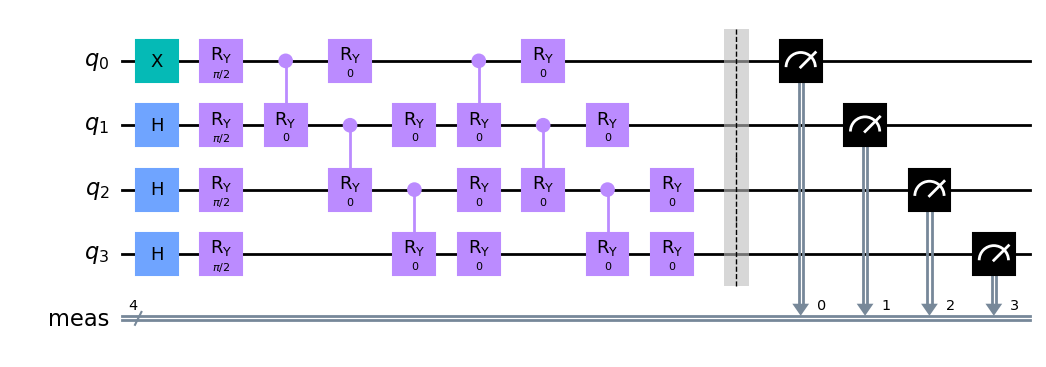

In [2]:
n_qbits=4
rep = 2

params = step1.get_init_params(n_qbits,rep)

qc = step1.ansatz(params,n_qbits,rep)
qc.measure_all()
display(qc.draw('mpl'))

In [3]:
K = 100 # strike price
sigma = 0.1 # volatility in %
T= 1
r = 0
Smin = 0
Smax = 150
n_qbits = 4
delta = (Smax - Smin)/(2**n_qbits-1) #price discretization

H = step1.hamiltonian(n_qbits, delta,  r, sigma)
print('Price step:',delta)
print(H)


Price step: 10.0
[[ 0.125  0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.005 -0.01   0.005  0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.005 -0.01   0.005  0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.005 -0.01   0.005  0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.005 -0.01   0.005  0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.005 -0.01   0.005  0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.005 -0.01   0.005  0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.005 -0.01   0.005  0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.005 -0.01   0.005

### **Step 2**: Build the initial state for the hybrid quantum-classical algorithm

In [4]:
K_quantum = 6 #Strike price when prices are represented by the computational basis

n_qbits = 4
rep = 2
params = step1.get_init_params(n_qbits,rep)

backend = Aer.get_backend('aer_simulator_statevector')


We need to define `cost_func(params)` within this notebook because `optimizer.minimize()` only admits functions with one argument. Therefore, if we want that `cost_func(params)` in sensitive to the number of qbits, the strike price and the backend machine it needs to be in the same file of these variables. Besides, we will define the rest of the functions here to provide full visibility of the most important part of the challenge.

In [5]:
def cost_func(params):
    """Compares the output distribution of our circuit with
    parameters `params` to the target distribution."""
    # Create circuit instance with paramters and simulate it
    qc = step1.ansatz(params, n_qbits, rep)
    qc.measure_all()
    qc_t = transpile(qc, backend)
    result = backend.run(qc_t).result()
    # Get the counts for each measured state, and convert those counts into a probability dict
    output_distr = step2.counts_to_distr(result.get_counts())
    # Calculate the cost as the distance between the output distribution and the target distribution
    cost = sum(
        abs(step2.create_target_distr(n_qbits, K_quantum).get(i, 0) - output_distr.get(i, 0))
        for i in range(2**n_qbits)
    )
    return cost

def plot_optimized_amplitudes(optimized_result):
    qc = step1.ansatz(optimized_result.x, n_qbits,rep)
    qc.measure_all()
    qc_t = transpile(qc,backend)


    final_result = backend.run(qc_t, shots=int(1e5)).result()
    counts = final_result.get_counts()

    output_distr = step2.counts_to_distr(counts)
    output_amplitudes = step2.get_sorted_amplitudes(output_distr)

    fig, ax = plt.subplots()
    ax.spines['bottom'].set_position('zero')
    ax.plot(output_amplitudes.keys(), output_amplitudes.values(), '--', color='g')
    plt.xlabel('S')
    plt.ylabel('Payoff')
    plt.title('European Call Option Payoff')
    plt.show()

### Optimization with SPSA

SPSA (Simultaneous Perturbation Stochastic Approximation) is a stochastic gradient descent method used for finding the optimal parameters of a function. It is well-suited for optimization problems that have noisy or uncertain gradients. SPSA uses a gradient estimate based on random perturbations of the input parameters, making it robust to noise in the function evaluation.

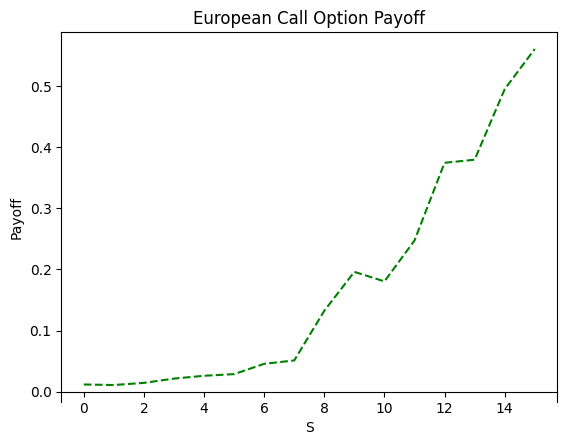

In [6]:
optimizer = SPSA(maxiter=1e3)
optimization_result = optimizer.minimize(fun=cost_func,x0=params)
plot_optimized_amplitudes(optimization_result)

### Optimization with COBYLA

COBYLA (Constrained Optimization BY Linear Approximation) is a derivative-free optimization method that is used for minimizing a function subject to constraints. COBYLA does not use gradient information and works by approximating the function with a linear model within a trust region of the input parameters.


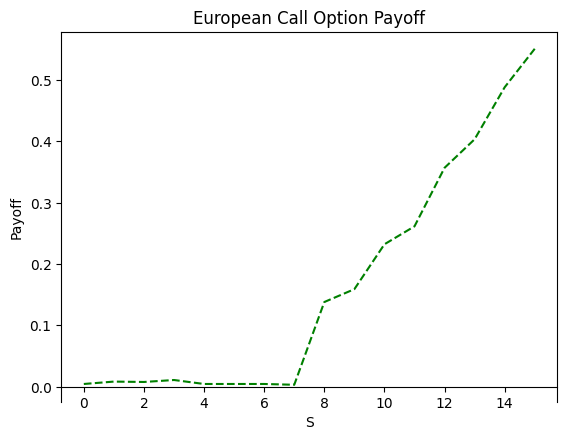

In [7]:
optimizer = COBYLA(maxiter=1e3, tol = 0.00001)
optimization_result = optimizer.minimize(fun=cost_func,x0=params)
plot_optimized_amplitudes(optimization_result)

Both SPSA and COBYLA are commonly used in quantum computing for optimizing quantum circuits, as the noisy and constrained nature of quantum systems can make traditional optimization methods impractical. However, in this case COBYLA seems to provide more reasonable values, so we'll move on with those.

### **Step 3**: Simulate the hybrid quantum-classical routine to price an European call option

Until now we were trying hard to avoid spaghetti code but it's being impossible to refactor the code while keeping the same results, sorry about that :)

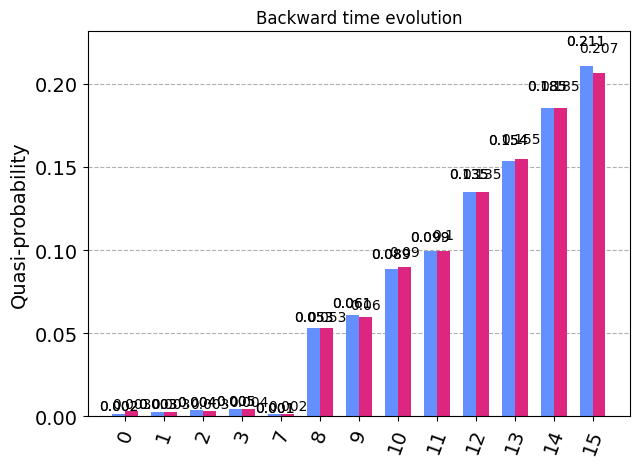

In [8]:
n_qubits=4
rep=2

H_fact = SparsePauliOp.from_operator(step1.hamiltonian(n_qbits, delta,  r, sigma))
pauli_op = PauliSumOp.from_list(H_fact.to_list())
param_vec = ParameterVector('θ', length=n_qubits + rep*(2*n_qubits-1))

observable = pauli_op

qc = step1.ansatz(optimization_result.x, n_qbits,rep)
qc.measure_all()
qc_t = transpile(qc,backend)

final_result = backend.run(qc_t, shots=int(1e5)).result()
counts = final_result.get_counts()

qc = step1.ansatz(param_vec, n_qubits=n_qubits, rep=rep)

time = 10

evolution_problem = TimeEvolutionProblem(observable, time=time*sigma**2)
var_qite = VarQITE(
    ansatz=qc,
    initial_parameters=optimization_result.x,
)
evolution_result = var_qite.evolve(evolution_problem)

qc = evolution_result.evolved_state
qc_t = transpile(qc, backend=backend)
params_step = evolution_result.parameter_values[-1]

qc = step1.ansatz(params=params_step, n_qubits=n_qubits, rep=rep)
qc.measure_all()
qc_t = transpile(qc, backend)
result_step = backend.run(qc_t, shots=int(1e5)).result()
counts_step = result_step.get_counts()
display(plot_histogram([step2.get_sorted_amplitudes(step2.counts_to_distr(counts)), 
                        step2.get_sorted_amplitudes(step2.counts_to_distr(counts_step))], 
                        title='Backward time evolution'))

/home/adria/Qiskit Hackathon/Qisikit_Hackathon_BCN/step1.py:26: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S0/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))


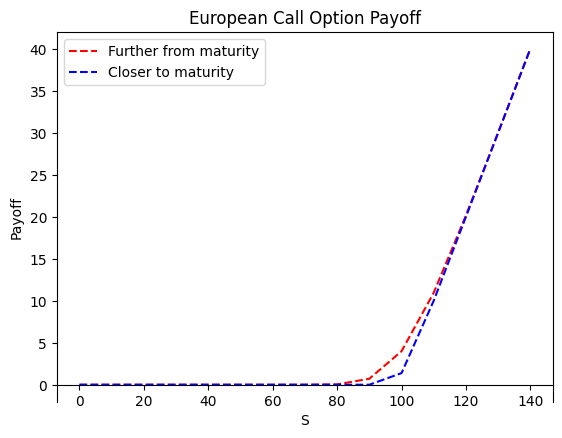

In [9]:
#Define range of stock price
K = 100 # strike price
sigma = 0.1 # volatility in %
r = 0
Smin = 0
Smax = 150
n_qbits = 4
delta = (Smax - Smin)/(2**n_qbits-1) #price discretization
S = np.arange(Smin,Smax,delta)

fig, ax = plt.subplots()
ax.spines['bottom'].set_position('zero')
t=1 #Note that t=0 means we are at maturity, we are moving backwards
ax.plot(S, step1.black_scholes_european_call_payoff(S, K, t, r, sigma), '--', color='red',label='Further from maturity')
t= 0.12 #Note that t=0 means we are at maturity, we are moving backwards
ax.plot(S, step1.black_scholes_european_call_payoff(S, K, t, r, sigma), '--', color = 'blue',label='Closer to maturity')
plt.xlabel('S')
plt.ylabel('Payoff')
plt.title('European Call Option Payoff')
plt.legend()
plt.show()

Note that our solution is consistent with the analytical solution of the Black-Scholes equation. Note that the red payoff is prior to the blue one, if time evolves forward.

### **Bonus points**:

- Run the hybrid quantum-classical on a QPU (optimize for given QPU connectivity). Reason whether you need state tomography, reason if possible to extract the information of interest (only the price call at the current date) with alternatives that require less expensive techniques. On a QPU or QASM  simulator, you only have access to short-estimated probabilities.

In [14]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider(token='6c9f1636d918f45281be268ee3cb6e459c55832516c5d974611c7ccd613704033843bce0fb9a0c962bb36387384a3e1e0754d3120747925e7cd2a4c38acd3684')
hub = "ibm-q-community"
group = "digiq-icfo-hack"
project = "main"
backend_name = "ibmq_jakarta" # 7 qubits
#backend_name = "ibmq_guadalupe	" # 16 qubits
backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")
shots = int(1024)# Number of shots to run each circuit for


n_qubits=4
rep=2

H_fact = SparsePauliOp.from_operator(step1.hamiltonian(n_qbits, delta,  r, sigma))
pauli_op = PauliSumOp.from_list(H_fact.to_list())
param_vec = ParameterVector('θ', length=n_qubits + rep*(2*n_qubits-1))

observable = pauli_op

qc = step1.ansatz(optimization_result.x, n_qbits,rep)
qc.measure_all()
qc_t = transpile(qc,backend)

final_result = backend.run(qc_t, shots=shots).result()
counts = final_result.get_counts()

qc = step1.ansatz(param_vec, n_qubits=n_qubits, rep=rep)

time = 10

evolution_problem = TimeEvolutionProblem(observable, time=time*sigma**2)
var_qite = VarQITE(
    ansatz=qc,
    initial_parameters=optimization_result.x,
)
evolution_result = var_qite.evolve(evolution_problem)

qc = evolution_result.evolved_state
qc_t = transpile(qc, backend=backend)
params_step = evolution_result.parameter_values[-1]

qc = step1.ansatz(params=params_step, n_qubits=n_qubits, rep=rep)
qc.measure_all()
qc_t = transpile(qc, backend)
result_step = backend.run(qc_t, shots=int(1e5)).result()
counts_step = result_step.get_counts()
display(plot_histogram([step2.get_sorted_amplitudes(step2.counts_to_distr(counts)), 
                        step2.get_sorted_amplitudes(step2.counts_to_distr(counts_step))], 
                        title='Backward time evolution'))

TranspilerError: 'Invalid plugin name ibm_dynamic_circuits for stage translation'

During the night we have been able to submit some jobs but the computers were unavailable. We only could finish one exeecution.

- Reason how to extend the algorithm to other type of options or to a multi-dimensional BS model.

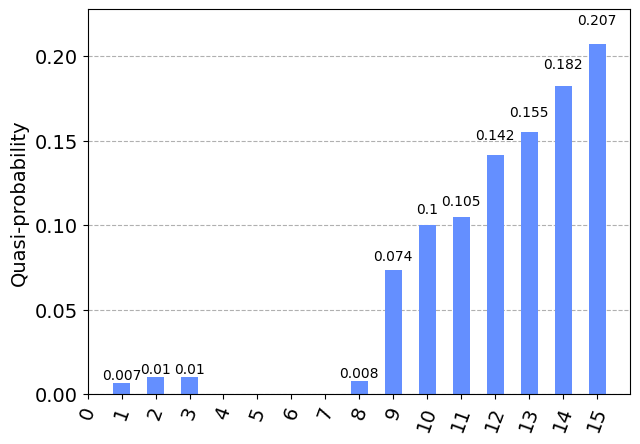

10.0
10.0
[[ 0.125  0.     0.     0.   ]
 [ 0.005 -0.01   0.005  0.   ]
 [ 0.     0.005 -0.01   0.005]
 [ 0.     0.     0.     0.125]]


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 11 and the array at index 1 has size 16

In [10]:
# define the varitional form
def ansatz_without(params, n_qubits, rep):
    """
        params are the trainable parameters
        n_qubits is the number of qubits in the ansatz
        rep is the repetation of the controlled-RY group
    """
    # giving exceptions
    if len(params) != n_qubits + rep*(2*n_qubits-1):
        raise Exception("the number of parameters doesn't match")
    if n_qubits < 2:
        raise Exception("not enought qubits to build the ansatz")
    if rep < 1:
        raise Exception("the repetation must be at least 1")
    if type(n_qubits) != int:
        raise Exception("the number of qubits must be an integar")
    if type(rep) != int:
        raise Exception("the number of repetation must be an integar")
    
    # build the circuit
    qc = QuantumCircuit(n_qubits)
    qc.x(0)
    qc.h(range(1, n_qubits))
    for n in range(n_qubits):
        qc.ry(params[n], n)
    for i in range(rep):
        for n in range(n_qubits-1):
            qc.cry(params[n_qubits+(2*n_qubits-1)*i+n], n, n+1)
            qc.ry(params[n_qubits+(2*n_qubits-1)*i+n+n_qubits-1], n)
        qc.ry(params[n_qubits+(2*n_qubits-1)*i+(2*n_qubits-2)], n_qubits-1)
    #display(qc.draw('mpl'))
    return qc

def ansatz(params, n_qubits, rep):
    qc = ansatz_without(params, n_qubits, rep)
    qc.measure_all()
    return qc

def get_init_params(n_qubits, rep):
    params = np.zeros(n_qubits + rep*(2*n_qubits-1))
    for i in range(n_qubits):
        params[i] = np.pi/2
    return params
n_qubits = 4
rep = 2
backend = Aer.get_backend('aer_simulator_statevector')
optimizer = SPSA(maxiter=1e3)

def counts_to_distr(counts):
    """
    Convert Qiskit result counts to dict with integers as
    keys, and pseudo-probabilities as values.
    """
    n_shots = sum(counts.values())
    return {int(k, 2): v/n_shots for k, v in counts.items()}

def counts_to_amp(counts):
    """
    Convert Qiskit result counts to dict with integers as
    keys, and pseudo-probabilities as values.
    """
    sq_dict = {key: np.sqrt(value) for key, value in counts.items()}
    n_shots2 = sum(sq_dict.values())
    return {int(k, 2): np.sqrt(v)/n_shots2 for k, v in counts.items()}

def creat_target_distr(n_qubits, cross_over):
    """
    cross_over is the last zero point
    """
    n_states = 2**n_qubits
    if cross_over >= n_states:
        raise Exception("open your eyes mate")
    end = n_states-cross_over-1
    cumulant = sum(np.linspace(1, end, end)**2)
    target_distr = {}
    for i in range(n_states):
        if i < cross_over:
            target_distr[i] = 0
        else:
            target_distr[i] = (i - cross_over)**2 / cumulant
    return target_distr

def cost_func_1(params):
    """Compares the output distribution of our circuit with
    parameters `params` to the target distribution."""
    # Create circuit instance with paramters and simulate it
    qc = ansatz(params, n_qubits, rep)
    qc_t = transpile(qc, backend)
    result = backend.run(qc_t).result()
    # Get the counts for each measured state, and convert
    # those counts into a probability dict
    output_distr = counts_to_distr(result.get_counts())
    # Calculate the cost as the distance between the output
    # distribution and the target distribution
    cost = sum(
        abs(target_distr.get(i, 0) - output_distr.get(i, 0))
        for i in range(2**n_qubits)
    )
    return cost

# initialization
params = np.zeros(n_qubits + rep*(2*n_qubits-1))
target_distr = creat_target_distr(
    n_qubits=4,
    cross_over=6
)

# optimization
result = optimizer.minimize(
    fun=cost_func_1,
    x0=params)

# Obtain the output distribution using the final parameters
qc = ansatz(result.x, n_qubits=n_qubits, rep=rep)
qc_t = transpile(qc,  backend)
final_result = backend.run(qc_t, shots=int(1e6)).result()
counts = final_result.get_counts()
output_amp = counts_to_amp(counts)
for i in range(2**n_qubits): 
    if i in output_amp:
        pass
    else:
        output_amp[i] = 0
display(plot_histogram(output_amp))

K = 100 # strike price
sigma = 0.4 # volatility in %
T= 1
r = 0
Smin = 0
Smax = 150
Nqubits = 4
delta = (Smax - Smin)/(2**Nqubits-1)

def hamiltonian(qubit_count, delta, r, sigma):

    dim = 2**qubit_count

    b = -1/2 * (1/2-r/sigma**2)**2-r/sigma**2
    print(delta)

    H = np.zeros((dim, dim))

    H[0][0] = -b*(2*delta**2)

    H[-1][-1] = -b*(2*delta**2)

    for i in range(1, dim-1):
    
        H[i][i-1] = 1

        H[i][i] = -2

        H[i][i+1] = 1

    return H*(1/(2*delta**2))

H_fact = SparsePauliOp.from_operator(hamiltonian(Nqubits, delta,  r, sigma))

pauli_op = PauliSumOp.from_list(H_fact.to_list())
H = hamiltonian(qubit_count=2, delta=delta, r=r, sigma=sigma)
print(H)

param_vec = ParameterVector('θ', length=n_qubits + rep*(2*n_qubits-1))

observable = pauli_op

qc = ansatz_without(param_vec, n_qubits=n_qubits, rep=rep)

time = 5
num_step = 2
evolution_problem = TimeEvolutionProblem(observable, time=sigma**2*time)
var_qite = VarQITE(
    ansatz=qc,
    initial_parameters=result.x,
    num_timesteps=num_step*time,
)
evolution_result = var_qite.evolve(evolution_problem)

amp = counts_to_amp(counts)
time_evolve = np.array([amp[key] for key in sorted(amp)], ndmin=2).T
params_step = evolution_result.parameter_values
for i in range(1, len(params_step)):
    qc = ansatz(params=params_step[i], n_qubits=n_qubits, rep=rep)
    qc_t = transpile(qc, backend)
    result_step = backend.run(qc_t, shots=int(1e6)).result()
    amp_step = counts_to_amp(result_step.get_counts())
    for i in range(2**n_qubits): 
        if i in amp_step:
            pass
        else:
            amp_step[i] = 0
    amp_ndarray = [amp_step[key] for key in sorted(amp_step)]
    amp_ndarray = np.array(amp_ndarray, ndmin=2)
    time_evolve = np.append(time_evolve, amp_ndarray.T, axis=1)
    X = np.linspace(50, 150, 16)
Y = np.linspace(0, 5, time*num_step+1)
Y, X = np.meshgrid(Y, X)
plt.plot(time_evolve[:, 0])
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Y, X, time_evolve, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plot_histogram(counts_to_amp(result_step.get_counts()))

- Implement Montecarlo or Finite differences schemes to solve the simple option pricing exercise. A classical baseline to compare with is useful. Argue where does the hybrid quantum algortihm stand in terms of error, runtime and numerical stability or others.